# Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from PIL import Image 
import pydicom as dicom

import scipy

from scipy.fft import fft, fftfreq
import itertools
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import auc
from tkinter.filedialog import askdirectory
import tkinter as tk

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

import os
import csv
import pandas as pd

import pydicom as dicom

import imageio

# Define Path Directories

In [1]:
# Main Experiment Path
patM = 'C:/IBECPostDocDrive/2023_07_25_ScaffoldDiffusionMRIProcessing/NewExperimetns/Data_4wellchip_difusion/20230724_104854_4wellchip_MAR_4wellchip_scaffolddifussionD2O_1_1'

preDirs = ['314_PreInject1','318_PreInject2','328_PreInject3']
postDirs = ['317_PostInject1','324_PostInject2','330_PostInject3']

preIms = ['4wellchip_4wellchip_MAR_4wellchip_sc_E314_P1_Im1','4wellchip_4wellchip_MAR_4wellchip_sc_E318_P1_Im1','4wellchip_4wellchip_MAR_4wellchip_sc_E328_P1_Im1']
postIMs = ['4wellchip_4wellchip_MAR_4wellchip_sc_E317_P1_Im1','4wellchip_4wellchip_MAR_4wellchip_sc_E324_P1_Im1','4wellchip_4wellchip_MAR_4wellchip_sc_E330_P1_Im1']

# Total number of experiments to consider
tnp = len(preDirs)


# Define General Structures 

In [4]:
MPre=np.empty(tnp, dtype=object)
MPost=np.empty(tnp, dtype=object)
MBackPre=np.empty(tnp, dtype=object)
MBackPost=np.empty(tnp, dtype=object)
dsPre=np.empty(tnp, dtype=object)
dsPost=np.empty(tnp, dtype=object)


PreDat=np.empty(tnp, dtype=object)
PreDatBack=np.empty(tnp, dtype=object)
PostDat=np.empty(tnp, dtype=object)
PostDatBack=np.empty(tnp, dtype=object)

# Extract Masks and Images

In [22]:
for i in range(0,tnp):
    MPre[i] = scipy.ndimage.label(np.asarray(Image.open(patM+'/'+preDirs[i]+'/Mask.png'))/255)[0]
    MPost[i] = scipy.ndimage.label(np.asarray(Image.open(patM+'/'+postDirs[i]+'/Mask.png'))/255)[0]
    MBackPre[i] = np.asarray(Image.open(patM+'/'+preDirs[i]+'/MaskBack.png'))/255
    MBackPost[i] = np.asarray(Image.open(patM+'/'+postDirs[i]+'/MaskBack.png'))/255

    dsPre[i] = imageio.v2.imread(patM+'/'+preDirs[i]+'/pdata/1/dicom/'+preIms[i]+'.dcm')
    dsPost[i] = imageio.v2.imread(patM+'/'+postDirs[i]+'/pdata/1/dicom/'+postIMs[i]+'.dcm')

## Extract Data

In [23]:
for h in range(0,tnp):

    imsis = np.shape(MPre[h])
    bck1 = np.mean((MBackPre[h]*dsPre[h])[MBackPre[h]==1])+(2*np.std((MBackPre[h]*dsPre[h])[MBackPre[h]==1]))
    bck2 = np.mean((MBackPost[h]*dsPost[h])[MBackPost[h]==1])+(2*np.std((MBackPost[h]*dsPost[h])[MBackPost[h]==1]))

    PreDat[h] = [[((MPre[h]==k)*dsPre[h])[i,j]-bck1 for i in range(0,imsis[0]) for j in range(0,imsis[1]) if ((MPre[h]==k)*dsPre[h])[i,j] != 0] for k in range(1,5)]
    PreDatBack[h] = [[((MPost[h]==k)*dsPre[h])[i,j]-bck1 for i in range(0,imsis[0]) for j in range(0,imsis[1]) if ((MPost[h]==k)*dsPre[h])[i,j] != 0] for k in range(1,5)]

    PostDat[h] = [[((MPost[h]==k)*dsPost[h])[i,j]-bck2 for i in range(0,imsis[0]) for j in range(0,imsis[1]) if ((MPost[h]==k)*dsPost[h])[i,j] != 0] for k in range(1,5)]
    PostDatBack[h] = [[((MPre[h]==k)*dsPost[h])[i,j]-bck2 for i in range(0,imsis[0]) for j in range(0,imsis[1]) if ((MPre[h]==k)*dsPost[h])[i,j] != 0] for k in range(1,5)]

## Compute Ratios

In [25]:
mm1 = [([np.mean([PreDat[h][k][i] for i in range(len(PreDat[h][k])) if PreDat[h][k][i] > 0])/
    np.mean([PreDatBack[h][k][i] for i in range(len(PreDatBack[h][k])) if PreDatBack[h][k][i] > 0]) for k in range(0,4)]) for h in range(0,tnp)]
mm2 = [([np.mean([PostDatBack[h][k][i] for i in range(len(PostDatBack[h][k])) if PostDatBack[h][k][i] > 0])
    /np.mean([PostDat[h][k][i] for i in range(len(PostDat[h][k])) if PostDat[h][k][i] > 0]) for k in range(0,4)]) for h in range(0,tnp)]

In [38]:
for i in range(0,tnp):
    for j in range(4):
        if np.isnan(mm1[i][j]):
            mm1[i][j] = 0
        if np.isnan(mm2[i][j]):
            mm2[i][j] = 0    

# Plot Results

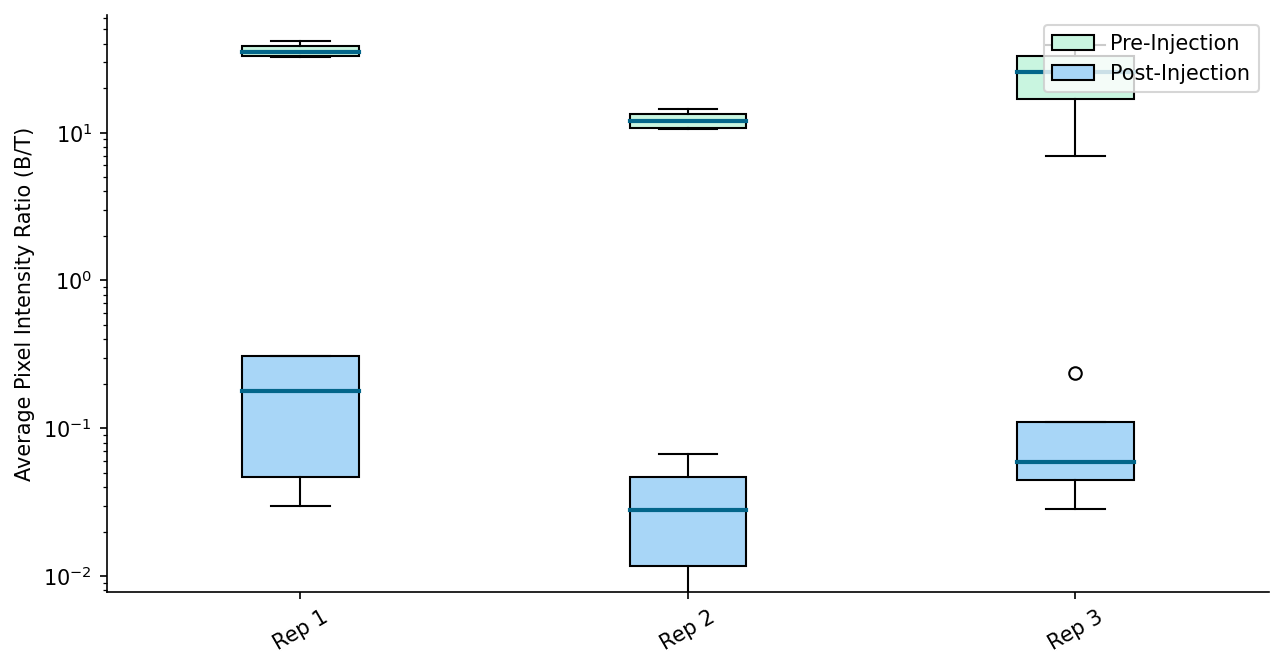

In [43]:

colors = '#C9F5E0'
colors2 = '#A8D6F7'

fig, ax = plt.subplots(dpi=150, figsize=(10,5))
pp1=ax.boxplot(mm1, patch_artist=True, boxprops=dict(facecolor=colors), medianprops = dict(color = "#03668A", linewidth = 2))#, showmeans = True, meanline = True)
pp2=ax.boxplot(mm2, patch_artist=True, boxprops=dict(facecolor=colors2), medianprops = dict(color = "#03668A", linewidth = 2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yscale('log')
plt.setp(ax.get_xticklabels(), rotation=30)
plt.xticks(list(range(1,tnp+1)), ['Rep '+str(list(range(1,tnp+1))[m]) for m in range(0,tnp)])

# plt.xlabel('Repetitions')
plt.ylabel('Average Pixel Intensity Ratio (B/T)')

ax.legend([pp1["boxes"][0], pp2["boxes"][0]], ['Pre-Injection', 'Post-Injection'], loc='upper right')

plt.savefig(patM+'/FastInjectionBoxPlots.png')
plt.savefig(patM+'/FastInjectionBoxPlots.svg')


plt.show()

# Extract Data in Mask Rows

Experiment 1


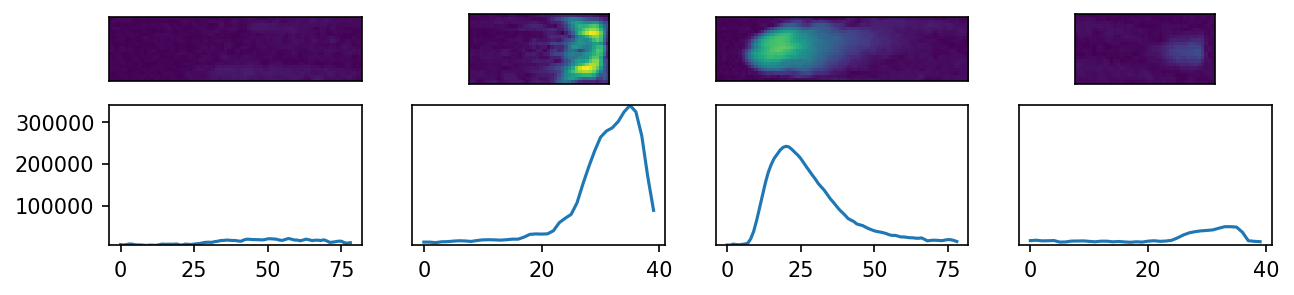

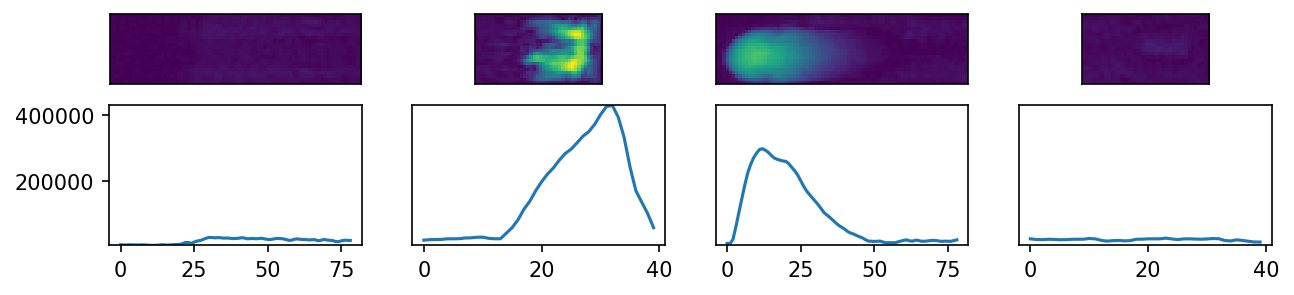

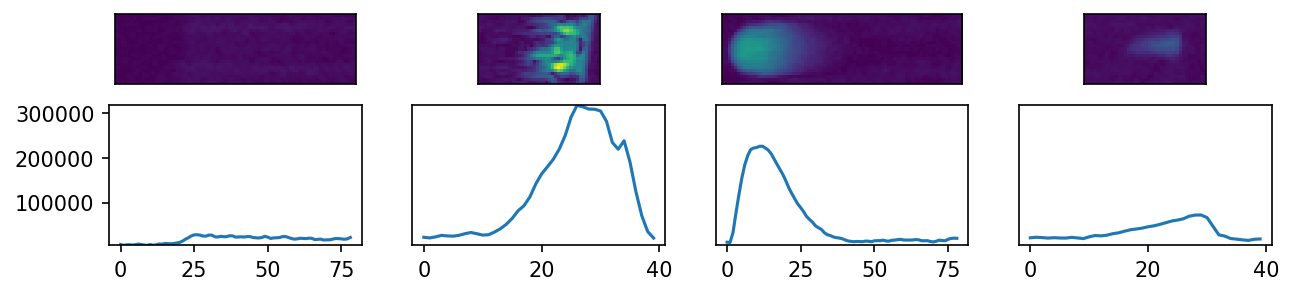

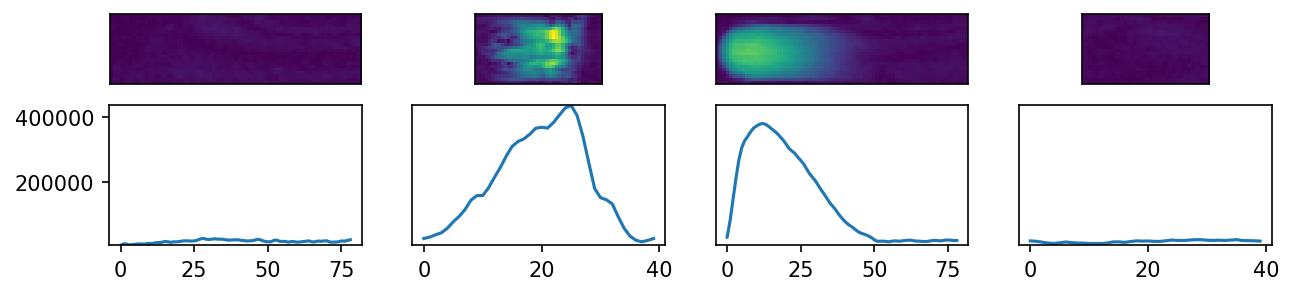

Experiment 2


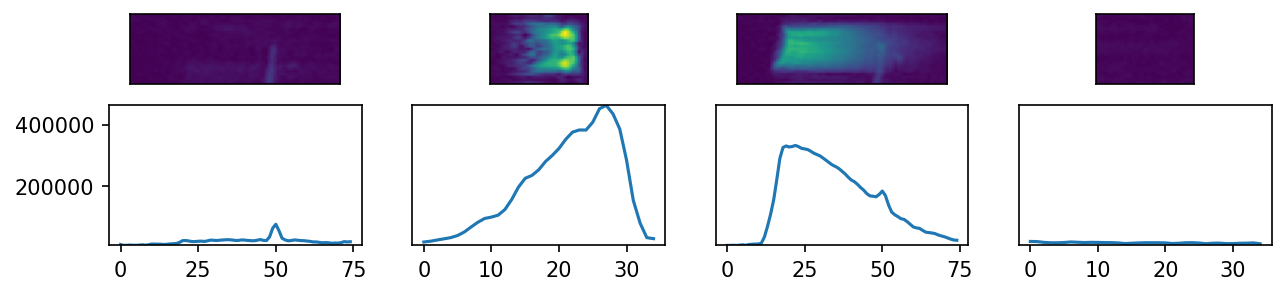

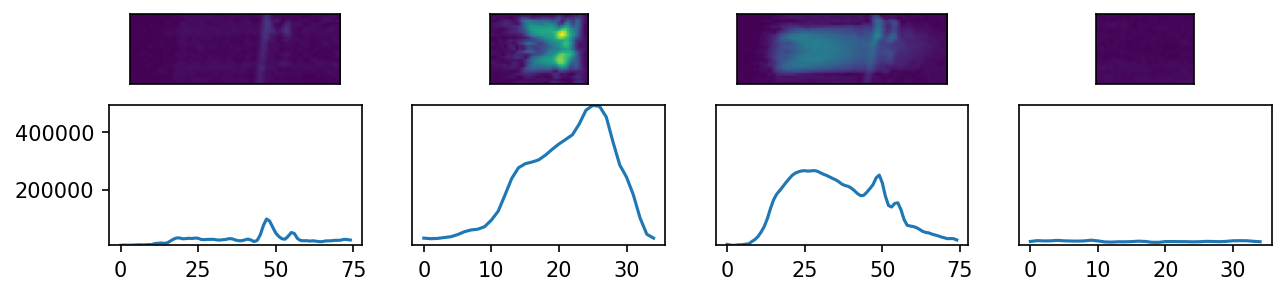

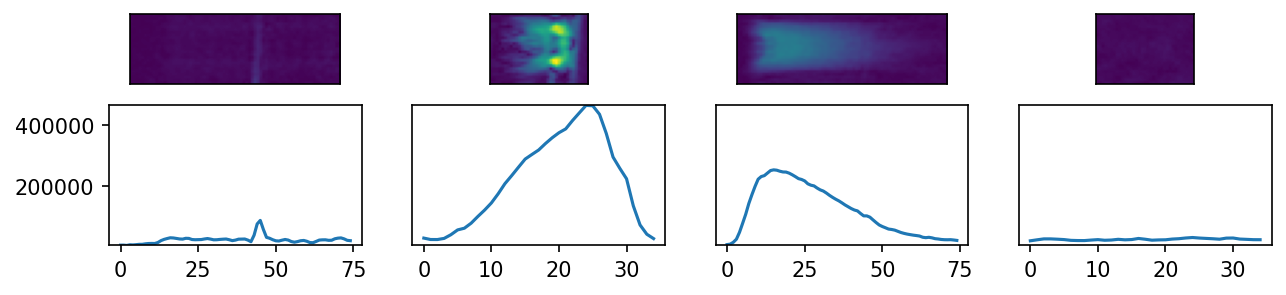

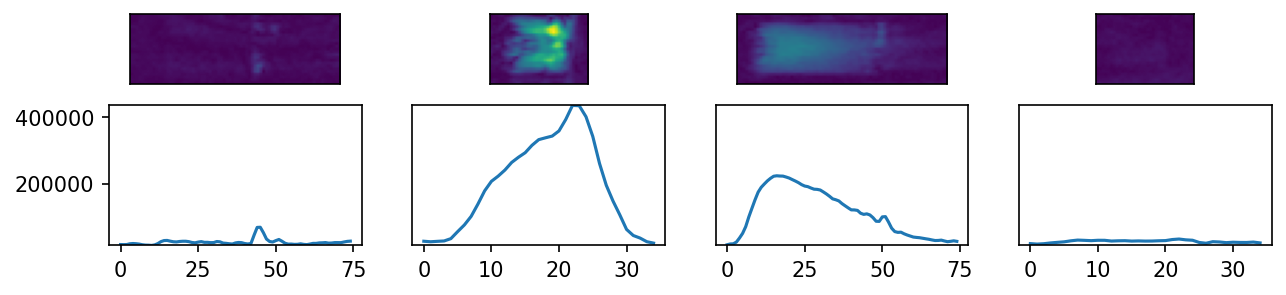

Experiment 3


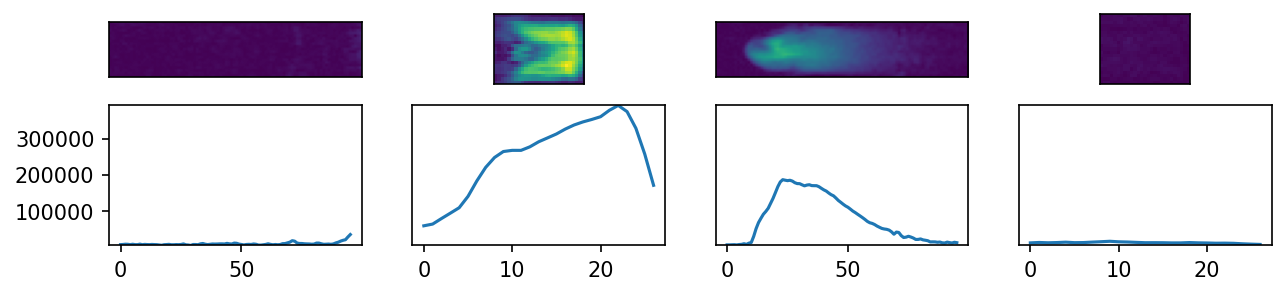

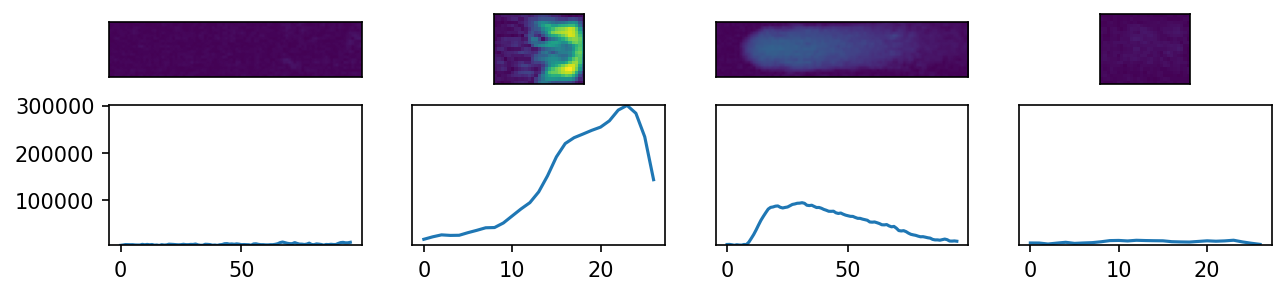

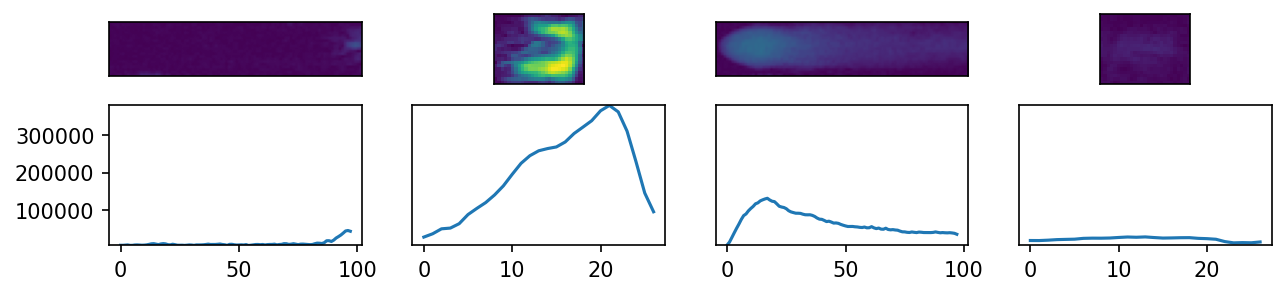

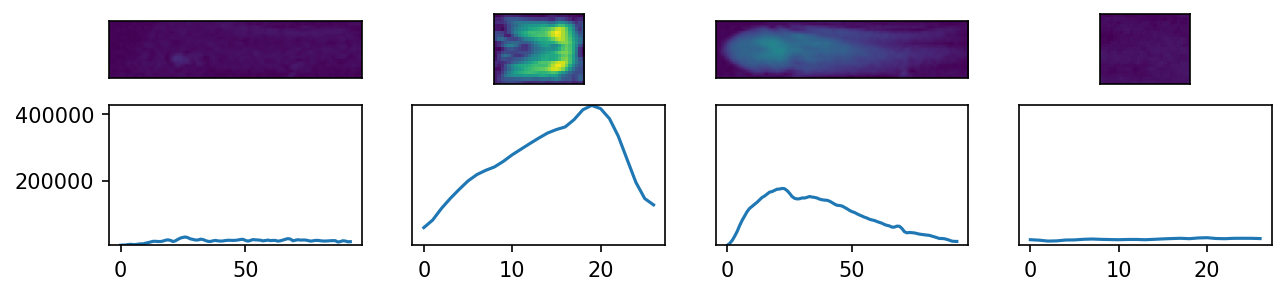

In [44]:
for h in range(tnp):

    print('Experiment '+str(h+1))

    for k in range(1,5):

        tm1 = dsPre[h][np.min(np.where(MPre[h]==k)[0]):np.max(np.where(MPre[h]==k)[0]), np.min(np.where(MPre[h]==k)[1]):np.max(np.where(MPre[h]==k)[1])]
        tm2 = dsPre[h][np.min(np.where(MPost[h]==k)[0]):np.max(np.where(MPost[h]==k)[0]), np.min(np.where(MPost[h]==k)[1]):np.max(np.where(MPost[h]==k)[1])]
        tm3 = dsPost[h][np.min(np.where(MPost[h]==k)[0]):np.max(np.where(MPost[h]==k)[0]), np.min(np.where(MPost[h]==k)[1]):np.max(np.where(MPost[h]==k)[1])]
        tm4 = dsPost[h][np.min(np.where(MPre[h]==k)[0]):np.max(np.where(MPre[h]==k)[0]), np.min(np.where(MPre[h]==k)[1]):np.max(np.where(MPre[h]==k)[1])]

        fig, axs = plt.subplots(2,4, dpi=150, figsize=(10,2), gridspec_kw={'height_ratios': [1, 2]})

        axs[0,0].imshow(tm2/np.max([np.max(tm1), np.max(tm2), np.max(tm3), np.max(tm4)]), vmin=0, vmax=1)
        axs[0,1].imshow(tm1/np.max([np.max(tm1), np.max(tm2), np.max(tm3), np.max(tm4)]), vmin=0, vmax=1)#, cmap='gray')
        axs[0,2].imshow(tm3/np.max([np.max(tm1), np.max(tm2), np.max(tm3), np.max(tm4)]), vmin=0, vmax=1)
        axs[0,3].imshow(tm4/np.max([np.max(tm1), np.max(tm2), np.max(tm3), np.max(tm4)]), vmin=0, vmax=1)


        # axs[0,0].imshow(tm2)#, cmap='gray')
        # axs[0,1].imshow(tm1)#, cmap='gray')
        # axs[0,2].imshow(tm3)
        # axs[0,3].imshow(tm4)


        axs[0,0].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        axs[0,1].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        axs[0,2].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        axs[0,3].tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)

        mins = min(min(np.sum(tm1, 0)), min(np.sum(tm2, 0)), min(np.sum(tm3, 0)), min(np.sum(tm4, 0)))
        maxs = max(max(np.sum(tm1, 0)), max(np.sum(tm2, 0)), max(np.sum(tm3, 0)), max(np.sum(tm4, 0)))

        axs[1,0].plot(np.sum(tm2, 0))
        axs[1,1].plot(np.sum(tm1, 0))
        axs[1,2].plot(np.sum(tm3, 0))
        axs[1,3].plot(np.sum(tm4, 0))

        axs[1,0].set_ylim(mins,maxs)
        axs[1,1].set_ylim(mins,maxs)
        axs[1,2].set_ylim(mins,maxs)
        axs[1,3].set_ylim(mins,maxs)

        axs[1,1].tick_params(left = False, right = False , labelleft = False)
        axs[1,2].tick_params(left = False, right = False , labelleft = False)
        axs[1,3].tick_params(left = False, right = False , labelleft = False)


        plt.savefig(patM+'/FastInjectionVisu_Exper'+str(h+1)+'_Well'+str(k)+'.png')
        plt.savefig(patM+'/FastInjectionVisu_Exper'+str(h+1)+'_Well'+str(k)+'.svg')

        plt.show()

# All pixel sum intensity

In [67]:
for h in range(tnp):

    print('Experiment '+str(h+1))

    for k in range(1,5):

        tm1 = dsPre[h][np.min(np.where(MPre[h]==k)[0]):np.max(np.where(MPre[h]==k)[0]), np.min(np.where(MPre[h]==k)[1]):np.max(np.where(MPre[h]==k)[1])]
        tm2 = dsPre[h][np.min(np.where(MPost[h]==k)[0]):np.max(np.where(MPost[h]==k)[0]), np.min(np.where(MPost[h]==k)[1]):np.max(np.where(MPost[h]==k)[1])]
        tm3 = dsPost[h][np.min(np.where(MPost[h]==k)[0]):np.max(np.where(MPost[h]==k)[0]), np.min(np.where(MPost[h]==k)[1]):np.max(np.where(MPost[h]==k)[1])]
        tm4 = dsPost[h][np.min(np.where(MPre[h]==k)[0]):np.max(np.where(MPre[h]==k)[0]), np.min(np.where(MPre[h]==k)[1]):np.max(np.where(MPre[h]==k)[1])]

    print((np.sum(tm1)+np.sum(tm2))/(np.sum(tm3)+np.sum(tm4)))


Experiment 1
0.77488935
Experiment 2
0.92136973
Experiment 3
0.93671936
